# Cross-Correlation


**Steps**:

1. Load CONUS dataset (5D, 14D temporal resolution)
2. Subset Area of Interest (AOI)
3. Interpolate the NANs
4. Smooth the Signal
5. Calculate the anomalies (remove the climatology)


## Package Preamble

In [1]:
import sys
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])


# append to path
sys.path.append(str(root))
sys.path.append("/home/emmanuel/code/isp_data")

# standard libraries
import geopandas as gpd
import xarray as xr
import numpy as np

xr.set_options(display_style="html")


# Helper Functions
from isp_data.drought.load import DroughtData
from isp_data.polygons import get_local_polygons
from isp_data.viz import plot_mean_time
from isp_data.esdc.subset import select_pixel, subset_bounding_box
from isp_data.esdc.decomposition import calculate_monthly_mean

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='poster',font_scale=0.7)


%load_ext autoreload
%autoreload 2

## Preprocessing Steps

1. Load Drought Data
2. Select Area of Interest
3. Interpolate the NANs
4. Smooth the Signal
5. Remove Climatology

#### Helper Plot Functions

In [2]:
def plot_ts(ds):
    fig, ax = plt.subplots(nrows=4, figsize=(10,10))


    ds.to_dataframe()[["VOD"]].plot(ax=ax[0], color="Blue")
    ds.to_dataframe()[["LST"]].plot(ax=ax[1], color="Red")
    ds.to_dataframe()[["NDVI"]].plot(ax=ax[2], color="Green")
    ds.to_dataframe()[["SM"]].plot(ax=ax[3], color="Red")

    plt.tight_layout()
    plt.show()

In [3]:
from isp_data.esdc.subset import Pixel, BoundingBox

In [40]:
import rioxarray

# ============================
# 1 - Load Drought Data
# ============================
region = 'conus'
sampling = '5D'

drought_data = DroughtData()

drought_cube = drought_data.load_data(region, sampling)

# ============================
# 2 - Select Area of Interest
# ============================
pixel = Pixel(lat=37, lon=-121)

# drought_cube.rio.clip_box(
#     minlat=36.34,
#     maxlat=50.03,
#     minlon=-104.52,
#     maxlon=-79.96,
# )

bounding_box = BoundingBox(36.34, 50.03, -104.52, -79.96)

# drought_cube = drought_cube.sel(
#     {"lat":slice(bounding_box.lat_min, bounding_box.lat_max),
#     "lon":slice(bounding_box.lon_min, bounding_box.lon_max)},
# )
demo_subset = subset_bounding_box(drought_cube, bounding_box)
demo_subset

<xarray.Dataset>
Dimensions:  (lat: 251, lon: 480, time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
  * lat      (lat) float64 36.39 36.44 36.49 36.54 ... 48.74 48.79 48.84 48.89
  * lon      (lon) float64 -104.5 -104.4 -104.4 -104.3 ... -80.64 -80.59 -80.54
Data variables:
    SMADI    (lat, lon, time) float64 ...
    LST      (lat, lon, time) float64 ...
    NDVI     (lat, lon, time) float64 ...
    VOD      (lat, lon, time) float64 ...
    SM       (lat, lon, time) float64 ...

/home/emmanuel/.conda/envs/isp_data/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


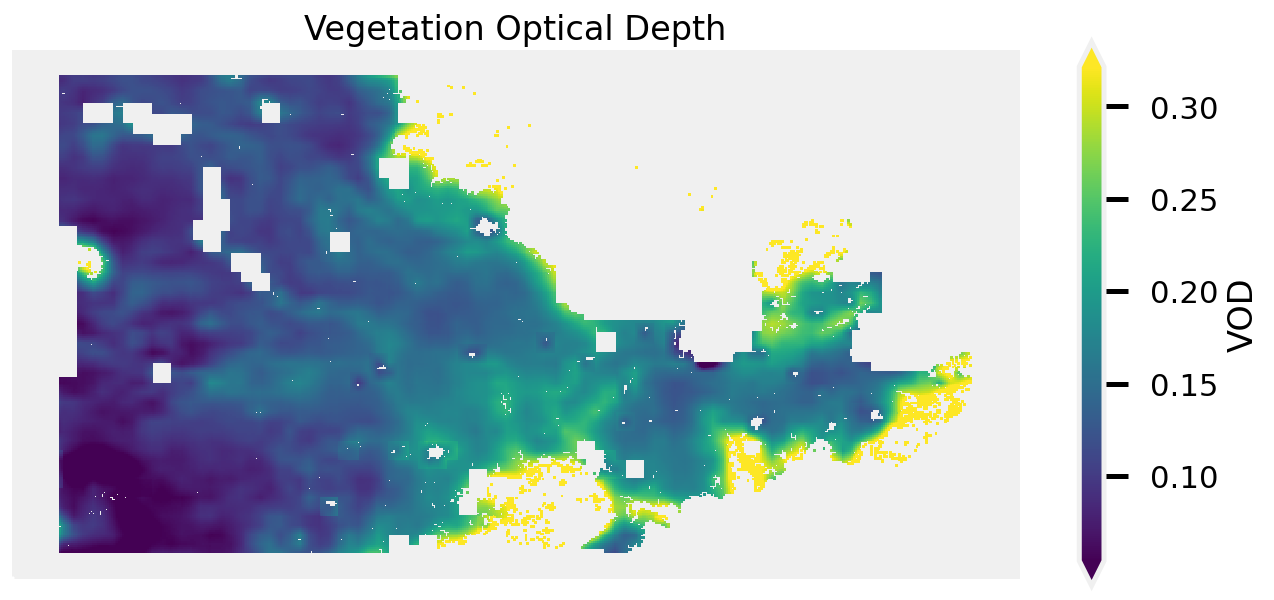

In [7]:
# plot
plot_mean_time(demo_subset.VOD, cmap="viridis", title="Vegetation Optical Depth", );

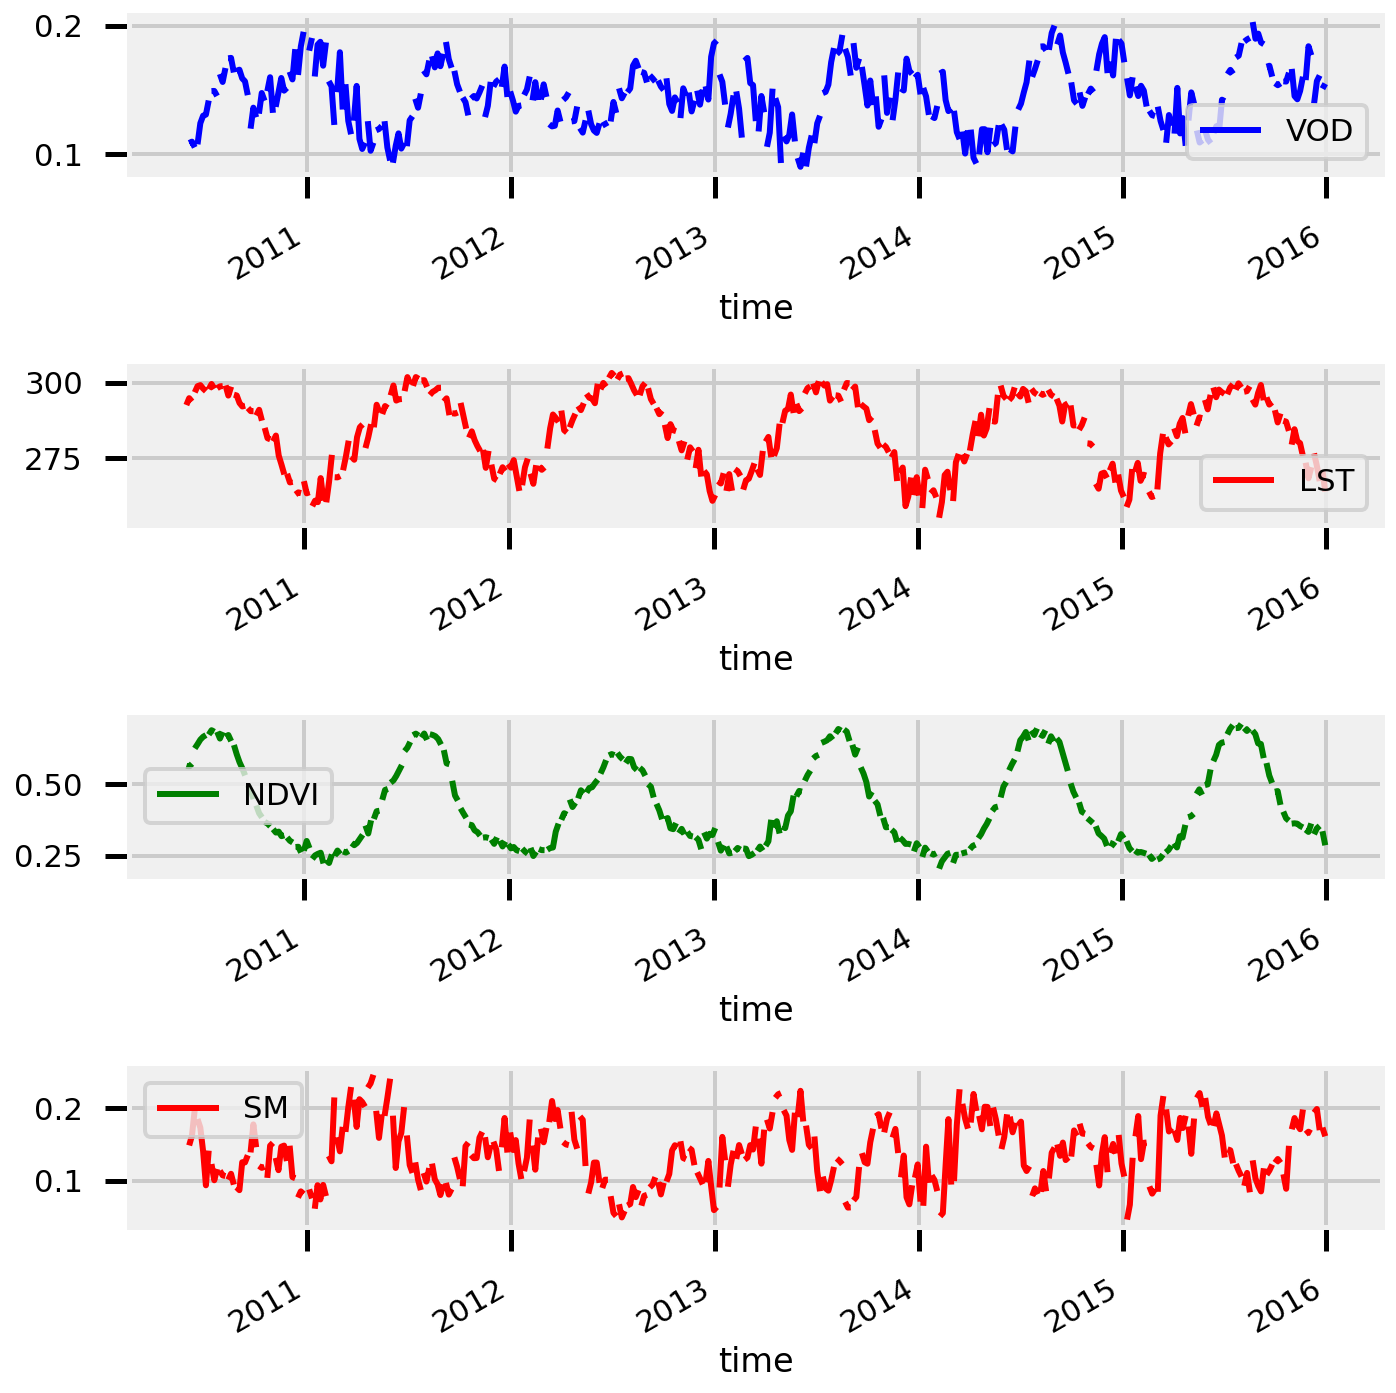

In [14]:
plot_ts(demo_subset.mean(dim=["lat", "lon"]))

### Interpolate NANs

In [112]:
%%time
# ======================
# 3 - Interpolate NANs
# ======================
# interpolation arguments
interp_dim = 'time'
method = 'linear'

# do interpolation
demo_subset_interp = demo_subset.copy()

demo_subset_interp["VOD"] = demo_subset.VOD.interpolate_na(
    dim=interp_dim, 
    method=method
)
demo_subset_interp["LST"] = demo_subset.LST.interpolate_na(
    dim=interp_dim, 
    method=method
)

demo_subset_interp["SM"] = demo_subset.SM.interpolate_na(
    dim=interp_dim, 
    method=method
)
demo_subset_interp["NDVI"] = demo_subset.NDVI.interpolate_na(
    dim=interp_dim, 
    method=method
)
demo_subset_interp

CPU times: user 13.6 s, sys: 828 ms, total: 14.4 s
Wall time: 14.4 s


<xarray.Dataset>
Dimensions:  (lat: 251, lon: 480, time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
  * lat      (lat) float64 36.39 36.44 36.49 36.54 ... 48.74 48.79 48.84 48.89
  * lon      (lon) float64 -104.5 -104.4 -104.4 -104.3 ... -80.64 -80.59 -80.54
Data variables:
    SMADI    (lat, lon, time) float64 ...
    LST      (lat, lon, time) float64 nan nan 293.8 312.8 ... nan nan nan nan
    NDVI     (lat, lon, time) float64 nan nan 0.3411 0.348 ... nan nan nan nan
    VOD      (lat, lon, time) float64 -0.02358 -0.01236 0.00447 ... nan nan nan
    SM       (lat, lon, time) float64 0.01119 0.004267 -0.006119 ... nan nan nan

In [115]:
demo_subset_interp.ffill(dim="time")

ModuleNotFoundError: No module named 'bottleneck'

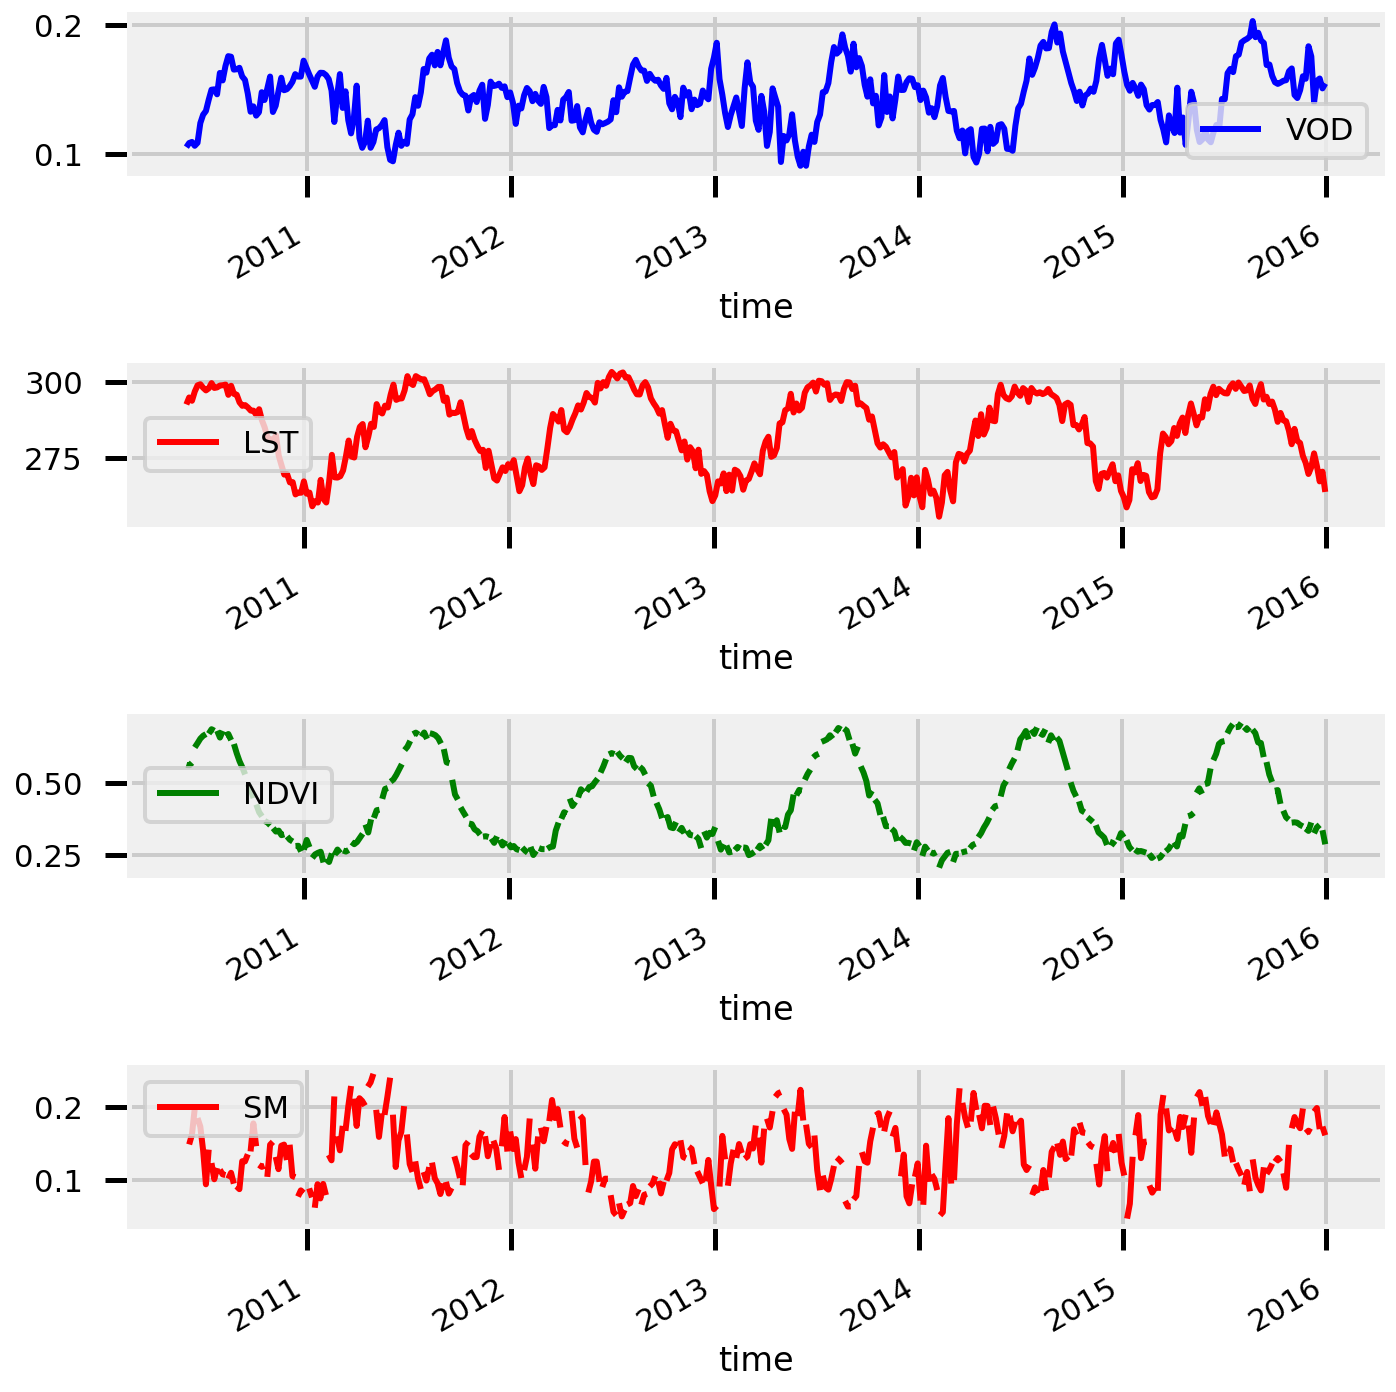

In [110]:
plot_ts(demo_subset_interp.mean(dim=["lat", "lon"]))

In [111]:
%%time

# ======================
# 4 - Smooth Signal
# ======================
# smoothing parameters
window_length = 3
center = True

# apply savgol filter
demo_subset_interp_rolling = demo_subset_interp.rolling(
    time=window_length, 
    center=center, 
).mean()
demo_subset_interp_rolling


CPU times: user 20.9 s, sys: 5.11 s, total: 26 s
Wall time: 26 s


<xarray.Dataset>
Dimensions:  (lat: 251, lon: 480, time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
  * lat      (lat) float64 36.39 36.44 36.49 36.54 ... 48.74 48.79 48.84 48.89
  * lon      (lon) float64 -104.5 -104.4 -104.4 -104.3 ... -80.64 -80.59 -80.54
Data variables:
    SMADI    (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    LST      (lat, lon, time) float64 nan nan nan 303.7 ... nan nan nan nan
    NDVI     (lat, lon, time) float64 nan nan nan 0.3437 nan ... nan nan nan nan
    VOD      (lat, lon, time) float64 nan -0.01049 0.03474 ... nan nan nan
    SM       (lat, lon, time) float64 nan nan nan 0.007536 ... nan nan nan nan

In [ ]:
# plot_ts(demo_subset_interp.mean(dim=["lat", "lon"]))

In [60]:
%%time

# =======================
# 5 - Remove Climatology
# =======================
# calculate the climatology
demo_subset_climatology_mean = calculate_monthly_mean(demo_subset_interp_rolling)

# remove climatology
dataset_anomalies = demo_subset_interp_rolling.groupby('time.month') - demo_subset_climatology_mean
dataset_anomalies

CPU times: user 5.94 s, sys: 3.3 s, total: 9.24 s
Wall time: 9.25 s


<xarray.Dataset>
Dimensions:  (lat: 251, lon: 480, time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
  * lat      (lat) float64 36.39 36.44 36.49 36.54 ... 48.74 48.79 48.84 48.89
  * lon      (lon) float64 -104.5 -104.4 -104.4 -104.3 ... -80.64 -80.59 -80.54
    month    (time) int64 5 6 6 6 6 6 6 6 6 7 ... 11 11 12 12 12 12 12 12 12 12
Data variables:
    SMADI    (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    LST      (lat, lon, time) float64 nan nan nan -0.6003 ... nan nan nan nan
    NDVI     (lat, lon, time) float64 nan nan nan 0.07998 ... nan nan nan nan
    VOD      (lat, lon, time) float64 nan -0.04006 0.005172 ... nan nan nan
    SM       (lat, lon, time) float64 nan -0.04644 -0.04247 ... nan nan nan

In [119]:
demo_subset_interp_rolling.VOD

<xarray.Dataset>
Dimensions:  (lat: 251, lon: 480, time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
  * lat      (lat) float64 36.39 36.44 36.49 36.54 ... 48.74 48.79 48.84 48.89
  * lon      (lon) float64 -104.5 -104.4 -104.4 -104.3 ... -80.64 -80.59 -80.54
Data variables:
    SMADI    (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    LST      (lat, lon, time) float64 nan nan nan 303.7 ... nan nan nan nan
    NDVI     (lat, lon, time) float64 nan nan nan 0.3437 nan ... nan nan nan nan
    VOD      (lat, lon, time) float64 nan -0.01049 0.03474 ... nan nan nan
    SM       (lat, lon, time) float64 nan nan nan 0.007536 ... nan nan nan nan

#### Plot Signal

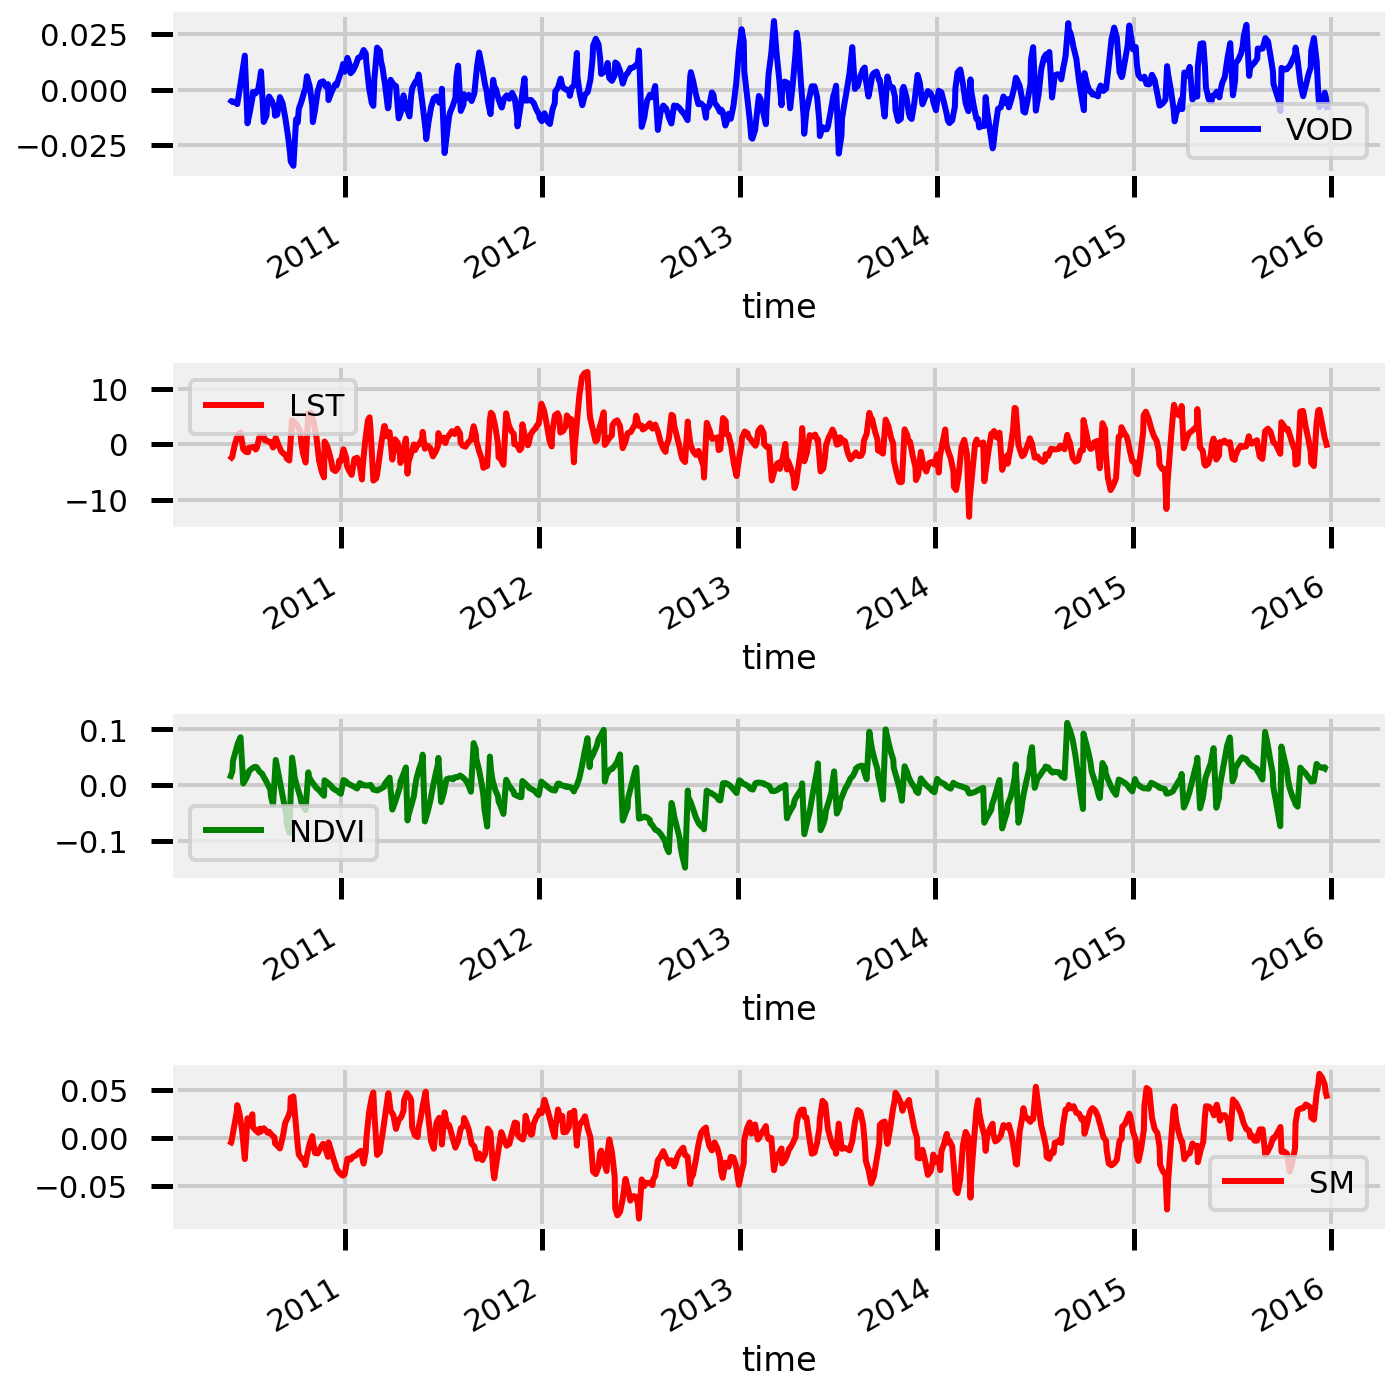

In [61]:
plot_ts(dataset_anomalies.mean(dim=["lat", "lon"]))

## AutoCorrelation (Self)

In [62]:
def autocorrelation(x: np.ndarray, symmetric: bool=True) -> np.ndarray:
    """Computes the autocorrlation of a signal
    
    Parameters
    ----------
    x : np.ndarray
        the input array, shape=(n_samples,)
    symmetric : bool, default=True
        whether to return the symmetric or not
    
    Returns
    -------
    auto_corr : np.ndarray
        the autocorrelation, shape=(n_samples,) or
        shape=(n_samples/2,) if symmetric is True
    """
    
    # remove the sample mean
    x -= np.mean(x)
    
    # compute lags
    n_samples = x.shape[0]
    lags = compute_lags(x)
    
    # compute cross correlation
    auto_corr = np.correlate(x, x, mode="full")
    
    # normalize by the zero-lag value
    auto_corr /= auto_corr[n_samples - 1]
    
    if symmetric:
        return auto_corr[n_samples-1:], lags[n_samples-1:]
    else:
        return auto_corr, lags


def compute_lags(x):
    """compute the lags"""
    return np.arange(-x.shape[0] + 1, x.shape[0])

## Cross Correlation

In [63]:
def cross_correlation(x: np.ndarray, y: np.ndarray, symmetric: bool=True) -> np.ndarray:
    """Computes the Autocorrelation between two signals
    
    Parameters
    ----------
    x : np.ndarray
        the input array
    y : np.ndarray
        the input array
    
    Returns
    -------
    cross_corr : np.ndarray
    the autocorrelation, shape=(n_samples,) or
    shape=(n_samples/2,) if symmetric is True
    """
    np.testing.assert_equal(x.shape, y.shape)
    
    # remove the sample mean
    x -= np.mean(x)
    y -= np.mean(y)
    
    # compute lags
    n_samples = x.shape[0]
    lags = compute_lags(x)
    
    # compute cross correlation
    cross_cov = np.correlate(x, y, mode="full")
    cross_corr = cross_cov / (n_samples * np.std(x) * np.std(y))
    
    if symmetric:
        return cross_corr[n_samples-1:], lags[n_samples-1:]
    else:
        return cross_corr, lags

In [64]:
def plot_crosscorr(ds, xlabel: str="Days"):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

    ds.VOD.plot(ax=ax[0,0], color="blue")
    ax[0,0].set(
        ylabel="Correlation Coefficient", title="VOD Auto Corr.", 
        xticklabels=[], xlabel=""
    )

    ds.LST.plot(ax=ax[0,1], color="red")
    ax[0,1].set(
        ylabel="", title="VOD vs Land Surface Temperature", 
        xticklabels=[], xlabel=""
    )

    ds.NDVI.plot(ax=ax[1,0], color="green")
    ax[1,0].set(
        xlabel=xlabel, ylabel="Correlation Coefficient", title="VOD vs NDVI"
    )


    ds.SM.plot(ax=ax[1,1], color="orange")
    ax[1,1].set(
        xlabel=xlabel, ylabel="", title="VOD vs Soil Moisture", 

    )


    plt.show()

    return None

In [123]:
# drop nans
crosscorr_variables = demo_subset_interp_rolling.dropna(dim="lat").dropna(dim="lon")
demo_subset_interp_rolling

<xarray.Dataset>
Dimensions:  (lat: 251, lon: 480, time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
  * lat      (lat) float64 36.39 36.44 36.49 36.54 ... 48.74 48.79 48.84 48.89
  * lon      (lon) float64 -104.5 -104.4 -104.4 -104.3 ... -80.64 -80.59 -80.54
Data variables:
    SMADI    (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan
    LST      (lat, lon, time) float64 nan nan nan 303.7 ... nan nan nan nan
    NDVI     (lat, lon, time) float64 nan nan nan 0.3437 nan ... nan nan nan nan
    VOD      (lat, lon, time) float64 nan -0.01049 0.03474 ... nan nan nan
    SM       (lat, lon, time) float64 nan nan nan 0.007536 ... nan nan nan nan

In [126]:
def body(x,y ):
    print(x.shape, y.shape)
    if np.isnan(np.sum(x)) or np.isnan(np.sum(x)):
        return np.nan * np.ones(x.shape[0])
    else:
        ac, _ = cross_correlation(x.values, y.values, True)
        return ac



f = xr.apply_ufunc(
    body,
    demo_subset_interp_rolling.LST,
    demo_subset_interp_rolling.VOD,
    input_core_dims=[["lat", "lon"], ["lat", "lon"]],
    output_core_dims=[["lat", "lon"]],
#     exclude_dims=set(("time",)),
    vectorize=True
)

(251, 480) (251, 480)


ValueError: 1-dimensional argument does not have enough dimensions for all core dimensions ('dim0', 'dim1')

In [147]:
crosscorr_variables

<xarray.Dataset>
Dimensions:  (lat: 0, lon: 480, time: 526)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-30 2010-06-01 ... 2015-12-30
  * lat      (lat) float64 
  * lon      (lon) float64 -104.5 -104.4 -104.4 -104.3 ... -80.64 -80.59 -80.54
Data variables:
    SMADI    (lat, lon, time) float64 
    LST      (lat, lon, time) float64 
    NDVI     (lat, lon, time) float64 
    VOD      (lat, lon, time) float64 
    SM       (lat, lon, time) float64

In [146]:

crosscorr_variables = demo_subset_interp_rolling.dropna(dim="lat").dropna(dim="lon")

def body(x,y ):
#     print(x.shape, y.shape)
#     print(type(x), type(y))
    if np.isnan(np.sum(x)) or np.isnan(np.sum(y)):
        nans = np.ones(x.shape[0])
        nans.fill(np.nan)
        return nans
    else:
        ac, _ = cross_correlation(x, y, True)
        
        return ac



f = xr.apply_ufunc(
    body,
    crosscorr_variables.LST,
    crosscorr_variables.VOD,
    input_core_dims=[["time", ], ["time"]],
    output_core_dims=[["time"]],
    exclude_dims=set(("time",)),
    vectorize=True
)

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

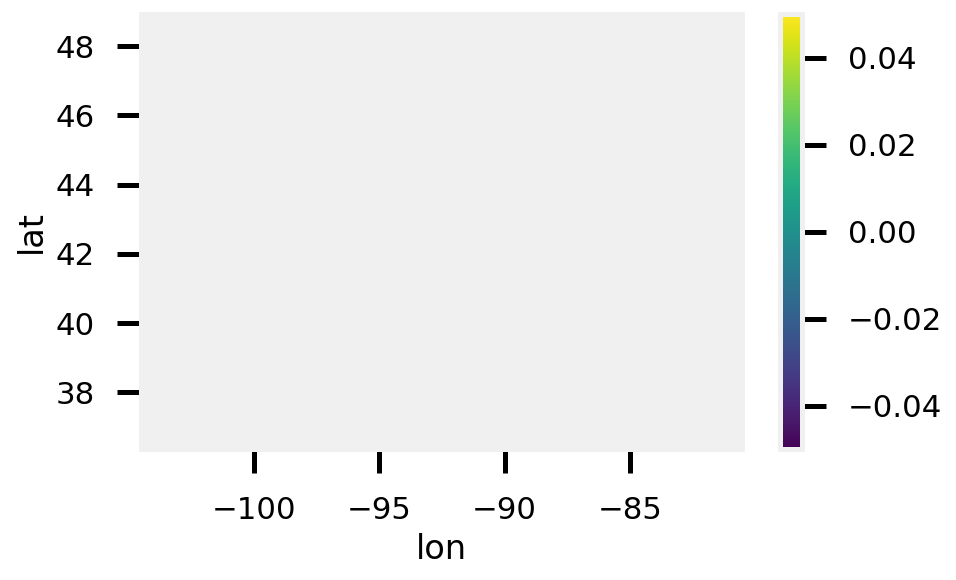

In [143]:
f.mean(dim="time").plot()

In [65]:
# drop nans
crosscorr_variables = demo_pixel_interp_rolling.dropna(dim="time")


# small hack to make it a single output function
def body(x):
    ac, _ = cross_correlation(x.values, crosscorr_variables.VOD.values, True)
    return ac

# compute autocorr for each of the variables
ds = crosscorr_variables.map(body)

/home/emmanuel/.conda/envs/isp_data/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/emmanuel/.conda/envs/isp_data/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: object too deep for desired array

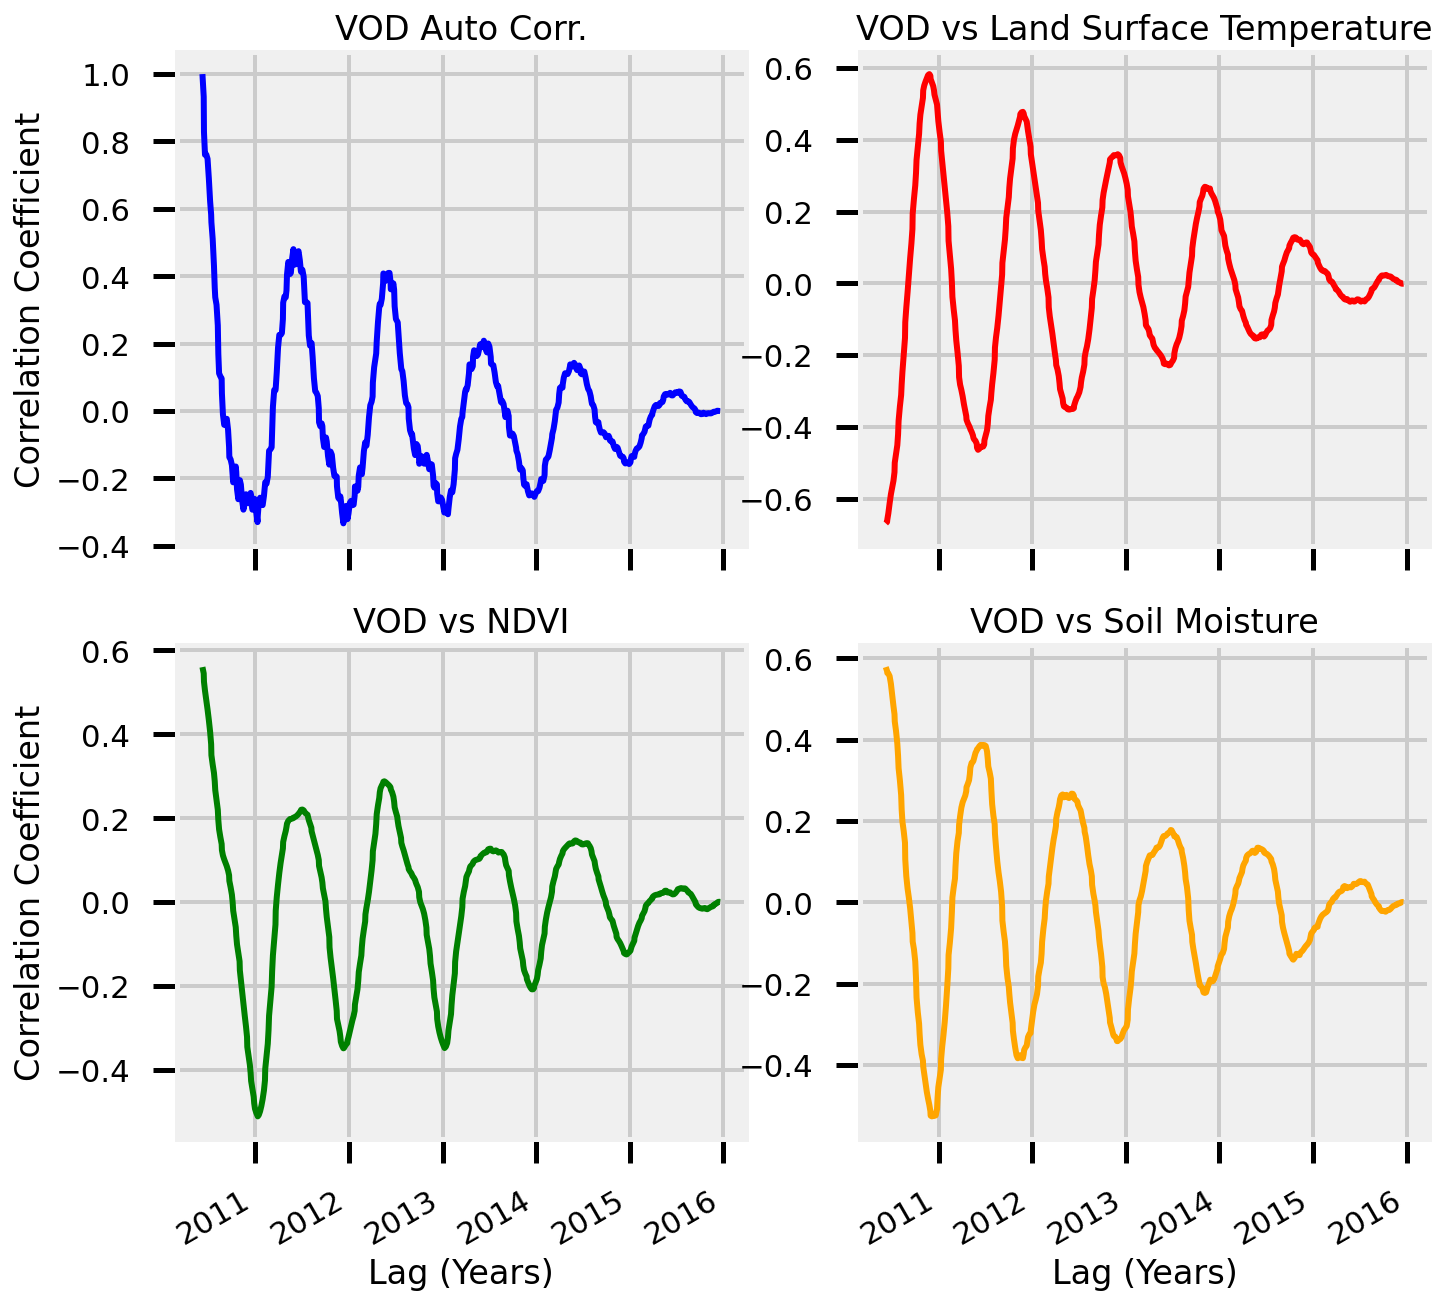

In [10]:
# combine the years
plot_crosscorr(ds, "Lag (Years)")

#### Groupby Years

In [11]:
# drop nans
crosscorr_variables = demo_pixel_interp_rolling.dropna(dim="time")

# copy the data array
crosscorr_variables = crosscorr_variables.copy()

# groupby year
crosscorr_variables = crosscorr_variables.groupby("time.year")




datasets = []

# loop through different years
for iyear, i_dataset in crosscorr_variables:
        
    # small hack to make it a single output function
    def body(x):
        ac, _ = cross_correlation(x.values, i_dataset.VOD.values, True)
        return ac
    # map each of the autocorrelations over each of the variables 
    i_dataset = i_dataset.map(body)
    
    # append the dataset to the list
    datasets.append(i_dataset)  

# merge the datasets
ds = xr.merge(datasets)


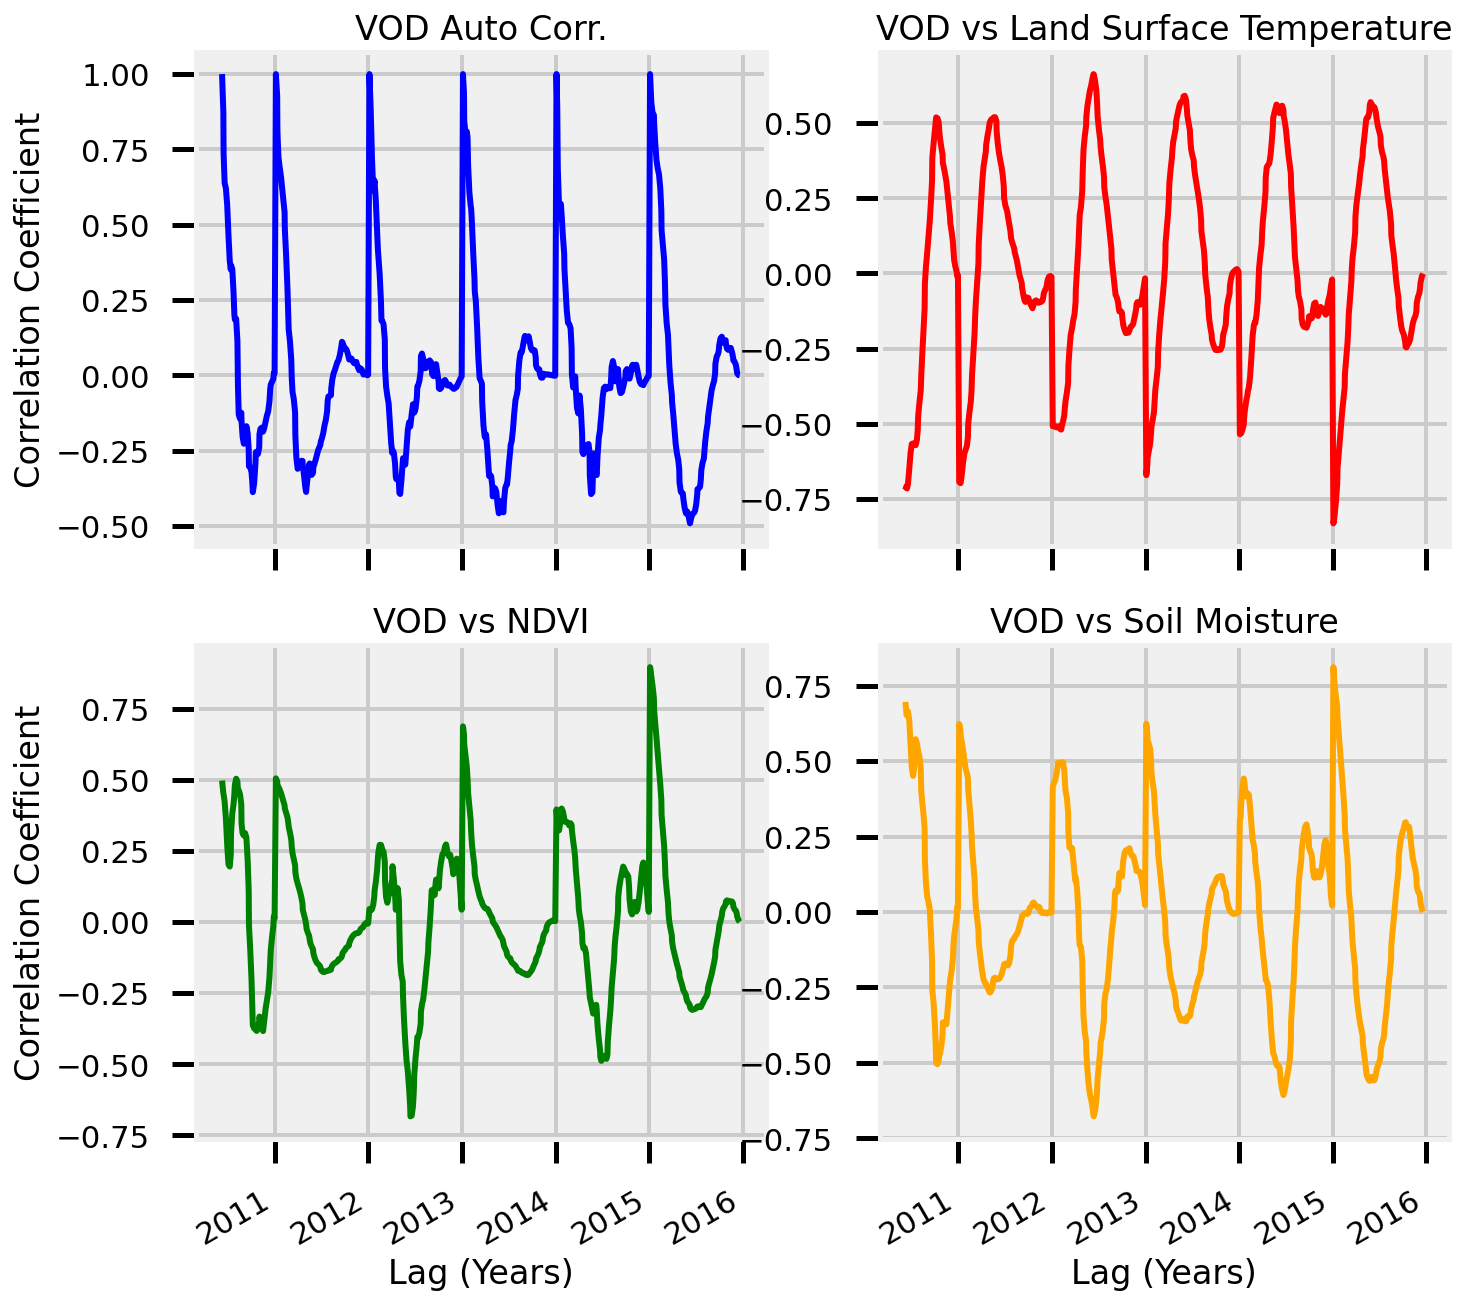

In [12]:
# combine the years
plot_crosscorr(ds, "Lag (Years)")

#### View Monthly

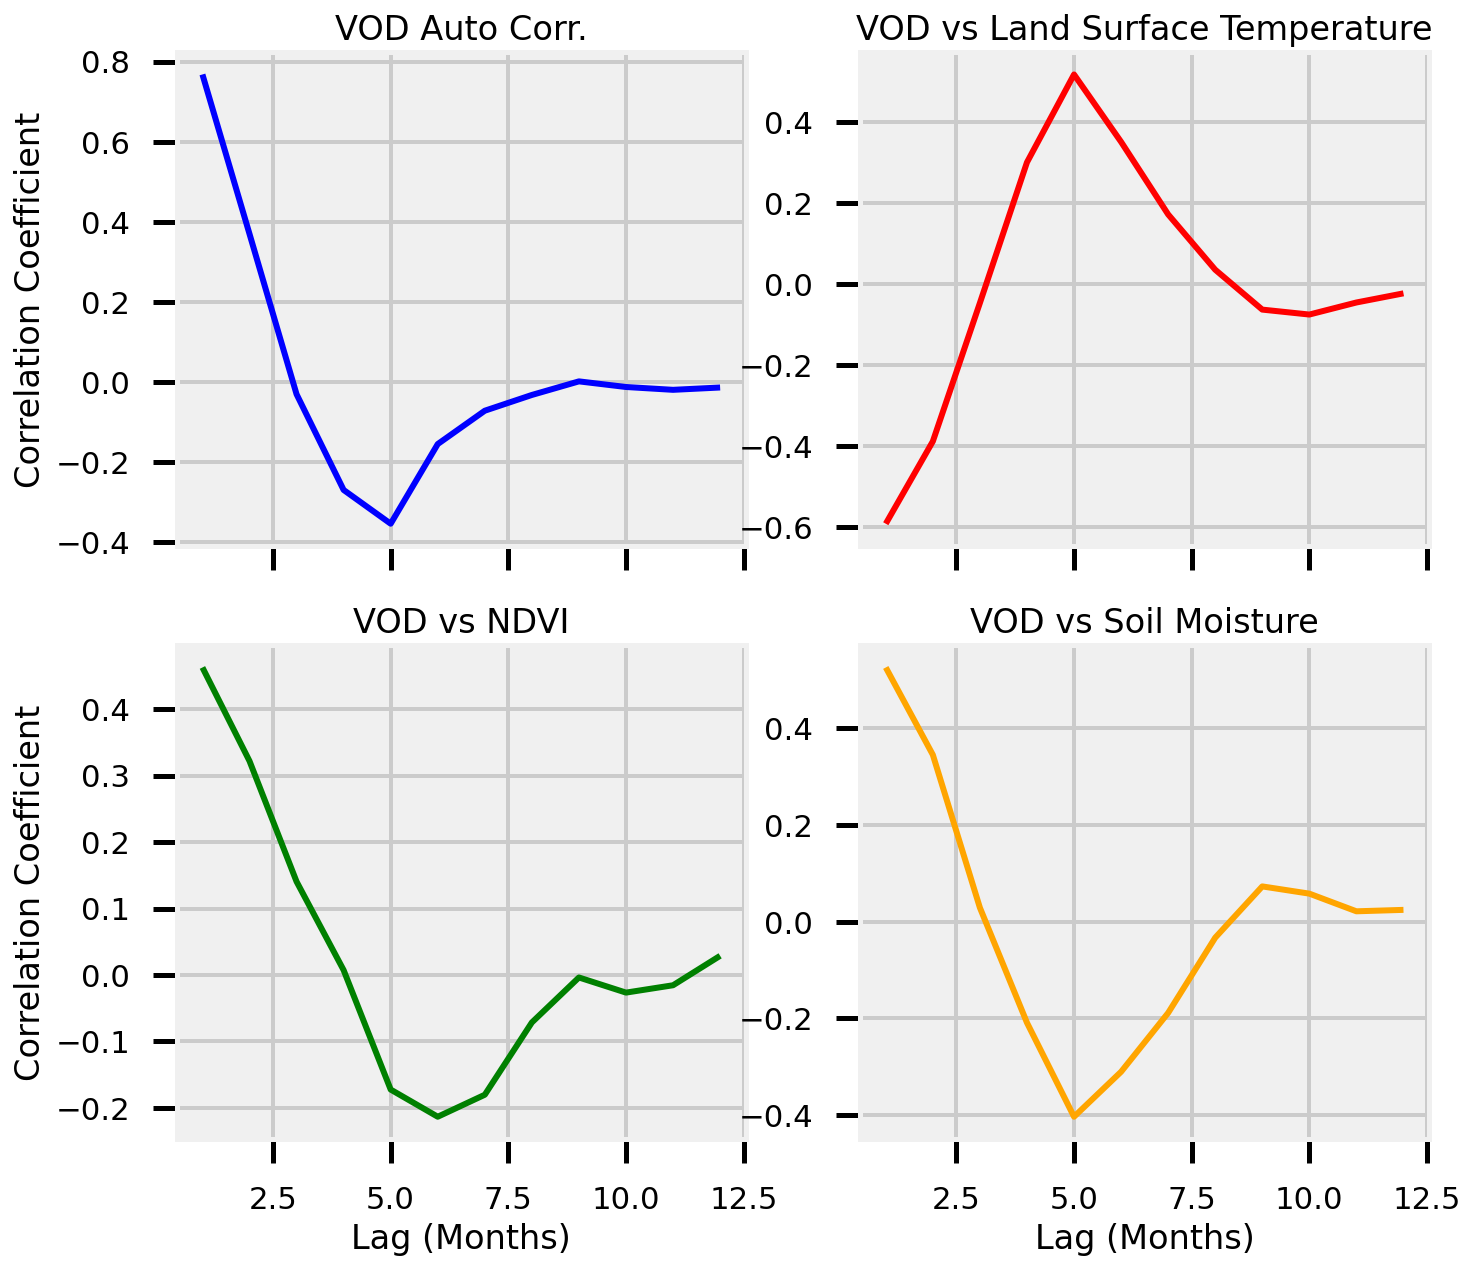

In [13]:
# combine the years
plot_crosscorr(ds.groupby("time.month").mean(), "Lag (Months)")

#### View Daily (per month)

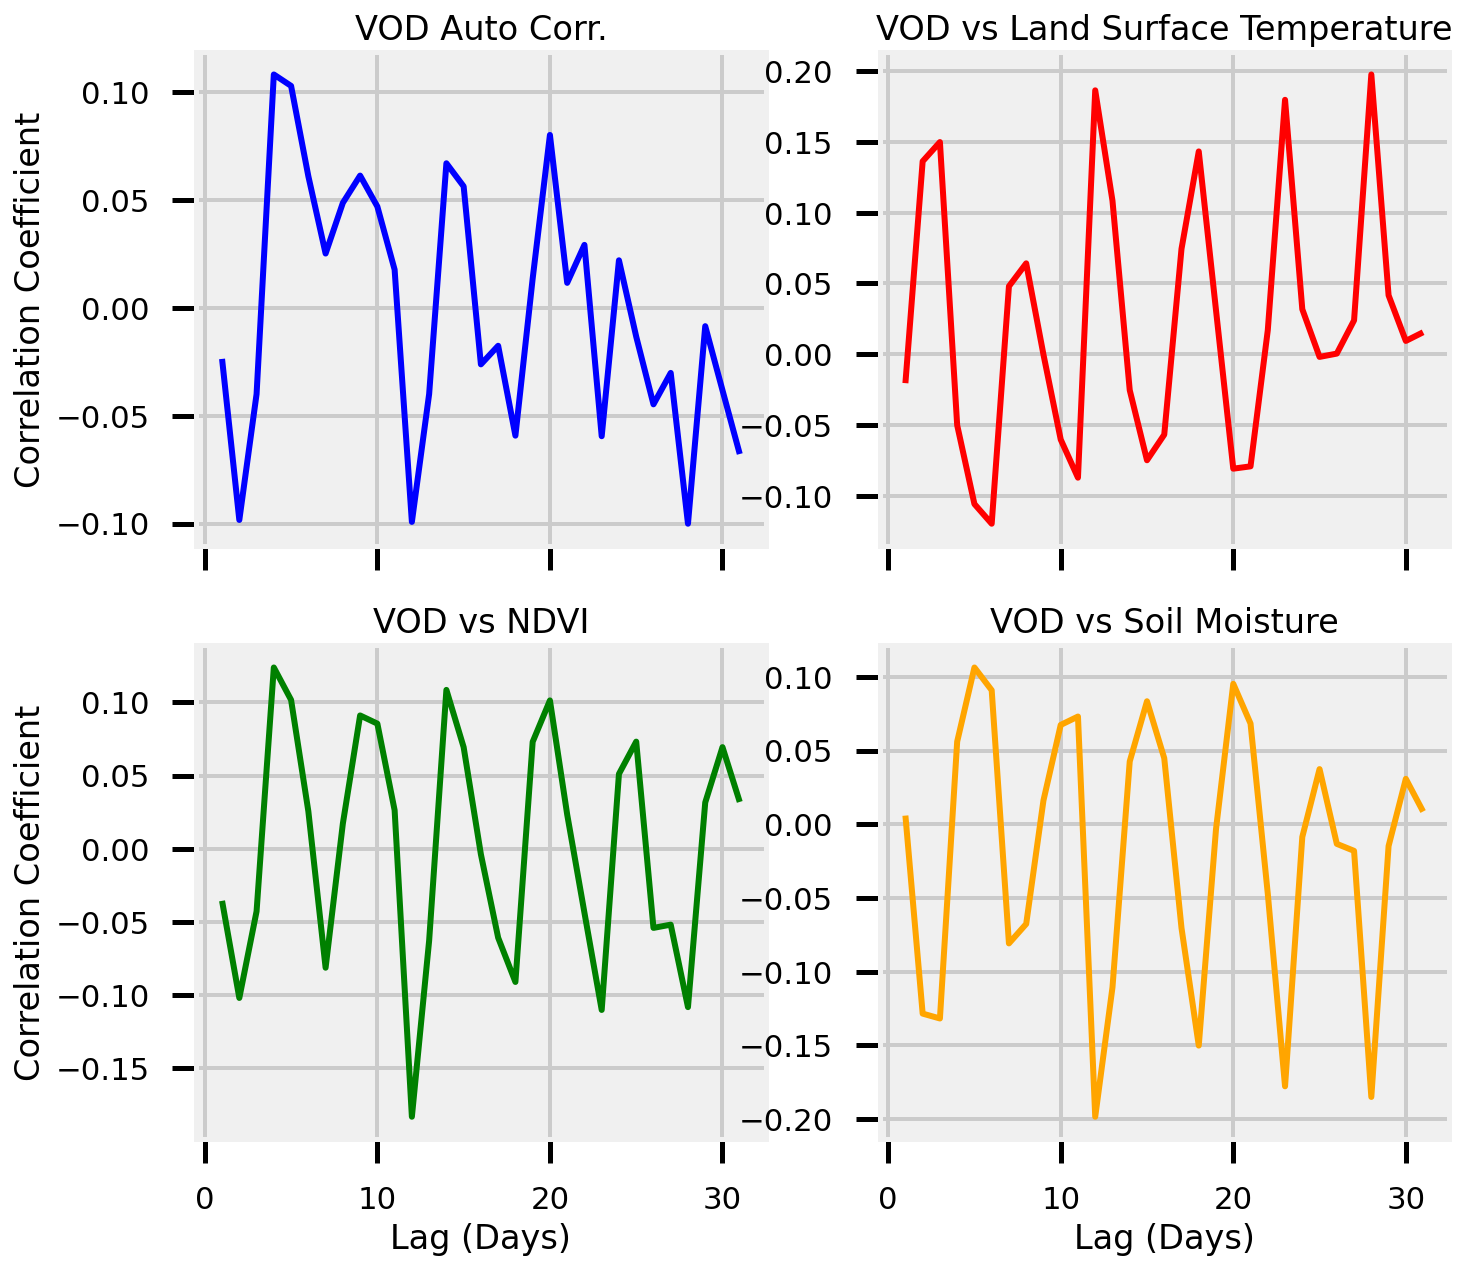

In [14]:

# combine the years
plot_crosscorr(ds.groupby("time.day").mean(), "Lag (Days)")

## Cross Correlation - Anomalies

In [15]:
# drop nans
crosscorr_variables = demo_pixel_anomalies.dropna(dim="time")


# small hack to make it a single output function
def body(x):
    ac, _ = cross_correlation(x.values, crosscorr_variables.VOD.values, True)
    return ac

# compute autocorr for each of the variables
ds = crosscorr_variables.map(body)

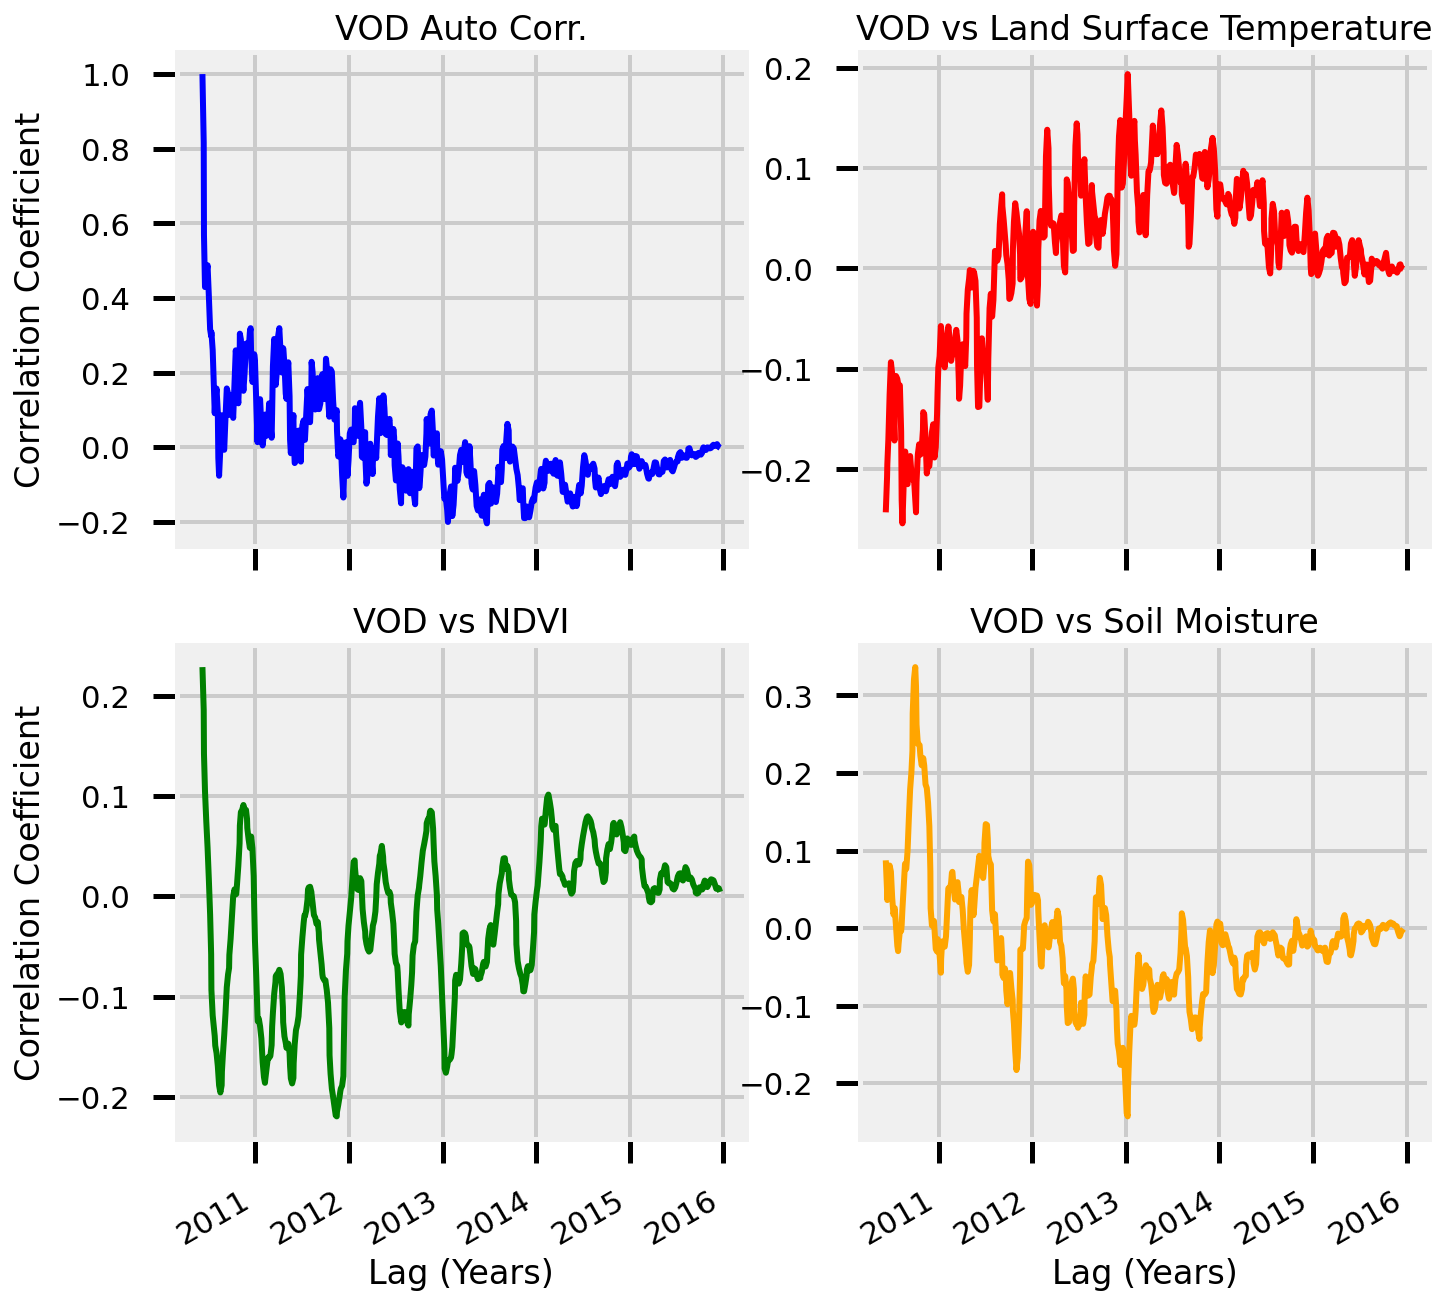

In [16]:
# combine the years
plot_crosscorr(ds, "Lag (Years)")

### Groupby Years

In [21]:
# drop nans
crosscorr_variables = demo_pixel_anomalies.dropna(dim="time")

# copy the data array
crosscorr_variables = crosscorr_variables.copy()

# groupby year
crosscorr_variables = crosscorr_variables.groupby("time.year")




datasets = []

# loop through different years
for iyear, i_dataset in crosscorr_variables:
        
    # small hack to make it a single output function
    def body(x):
        ac, _ = cross_correlation(x.values, i_dataset.VOD.values, True)
        return ac
    # map each of the autocorrelations over each of the variables 
    i_dataset = i_dataset.map(body)
    
    # append the dataset to the list
    datasets.append(i_dataset)  

# merge the datasets
ds = xr.merge(datasets)

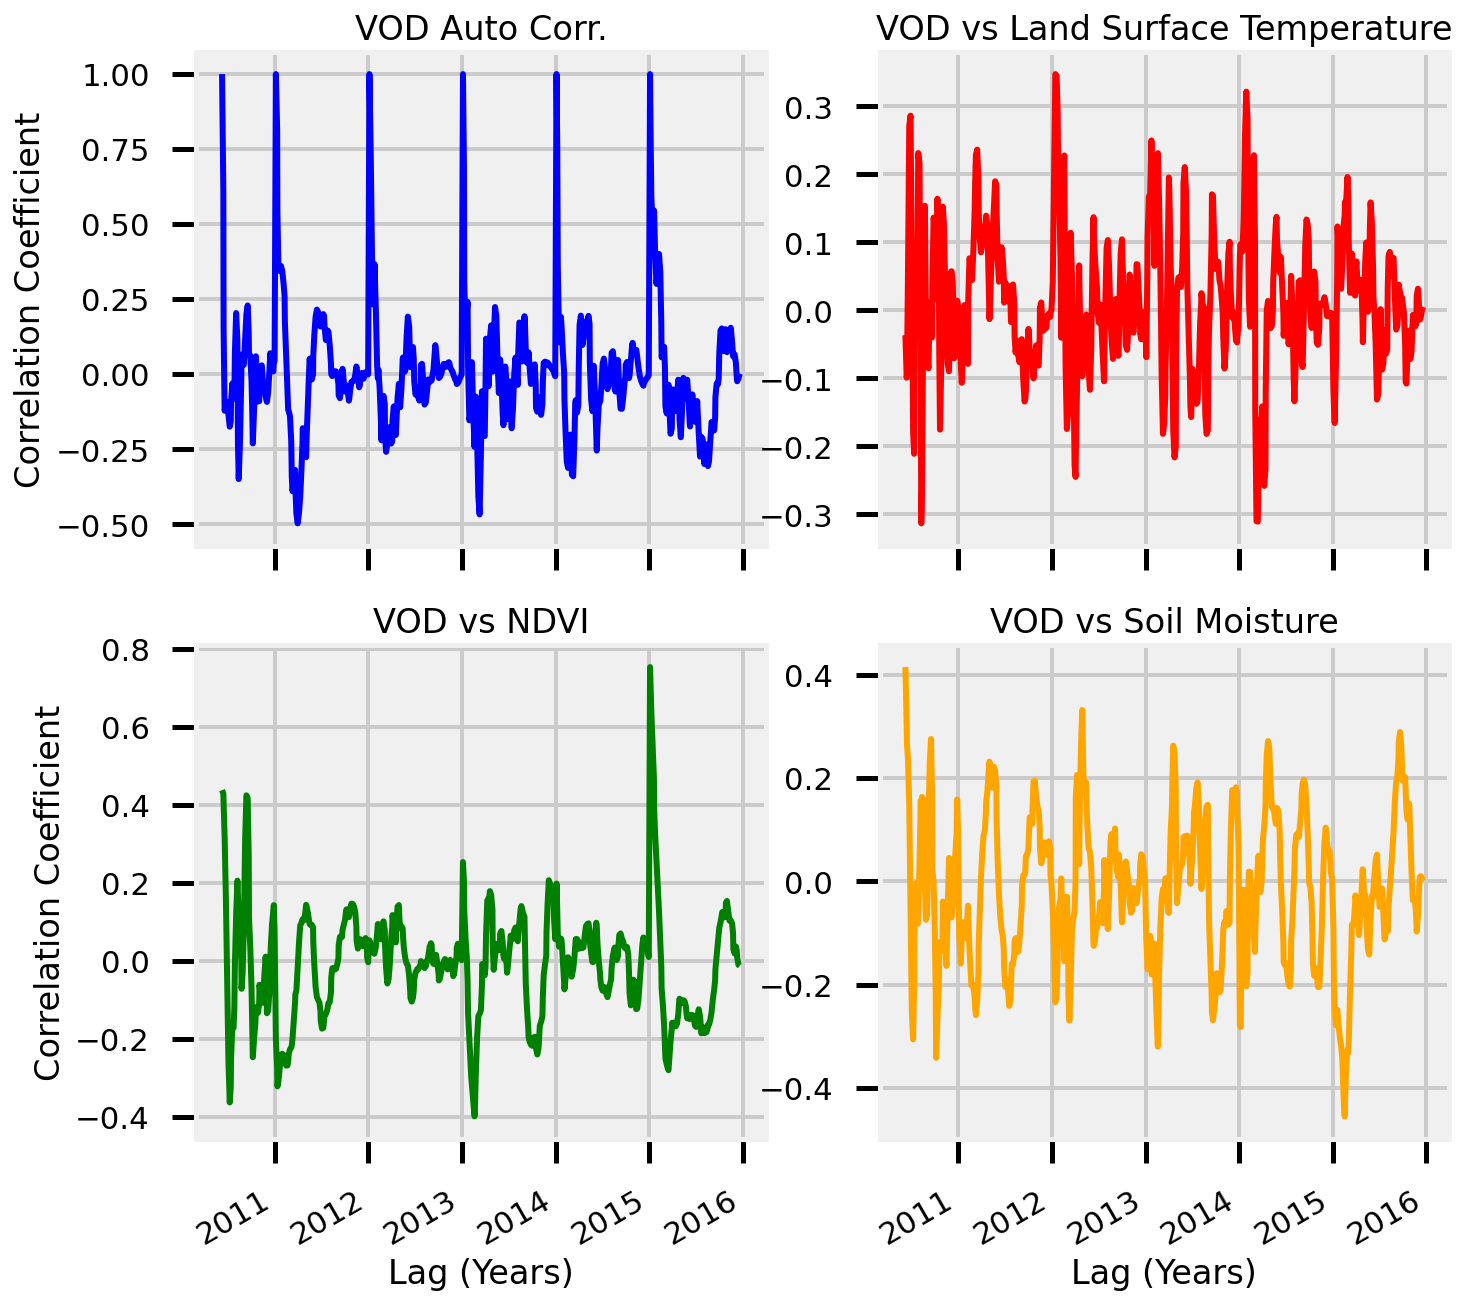

In [22]:
# combine the years
plot_crosscorr(ds, "Lag (Years)")

#### Average Per Year - By Month

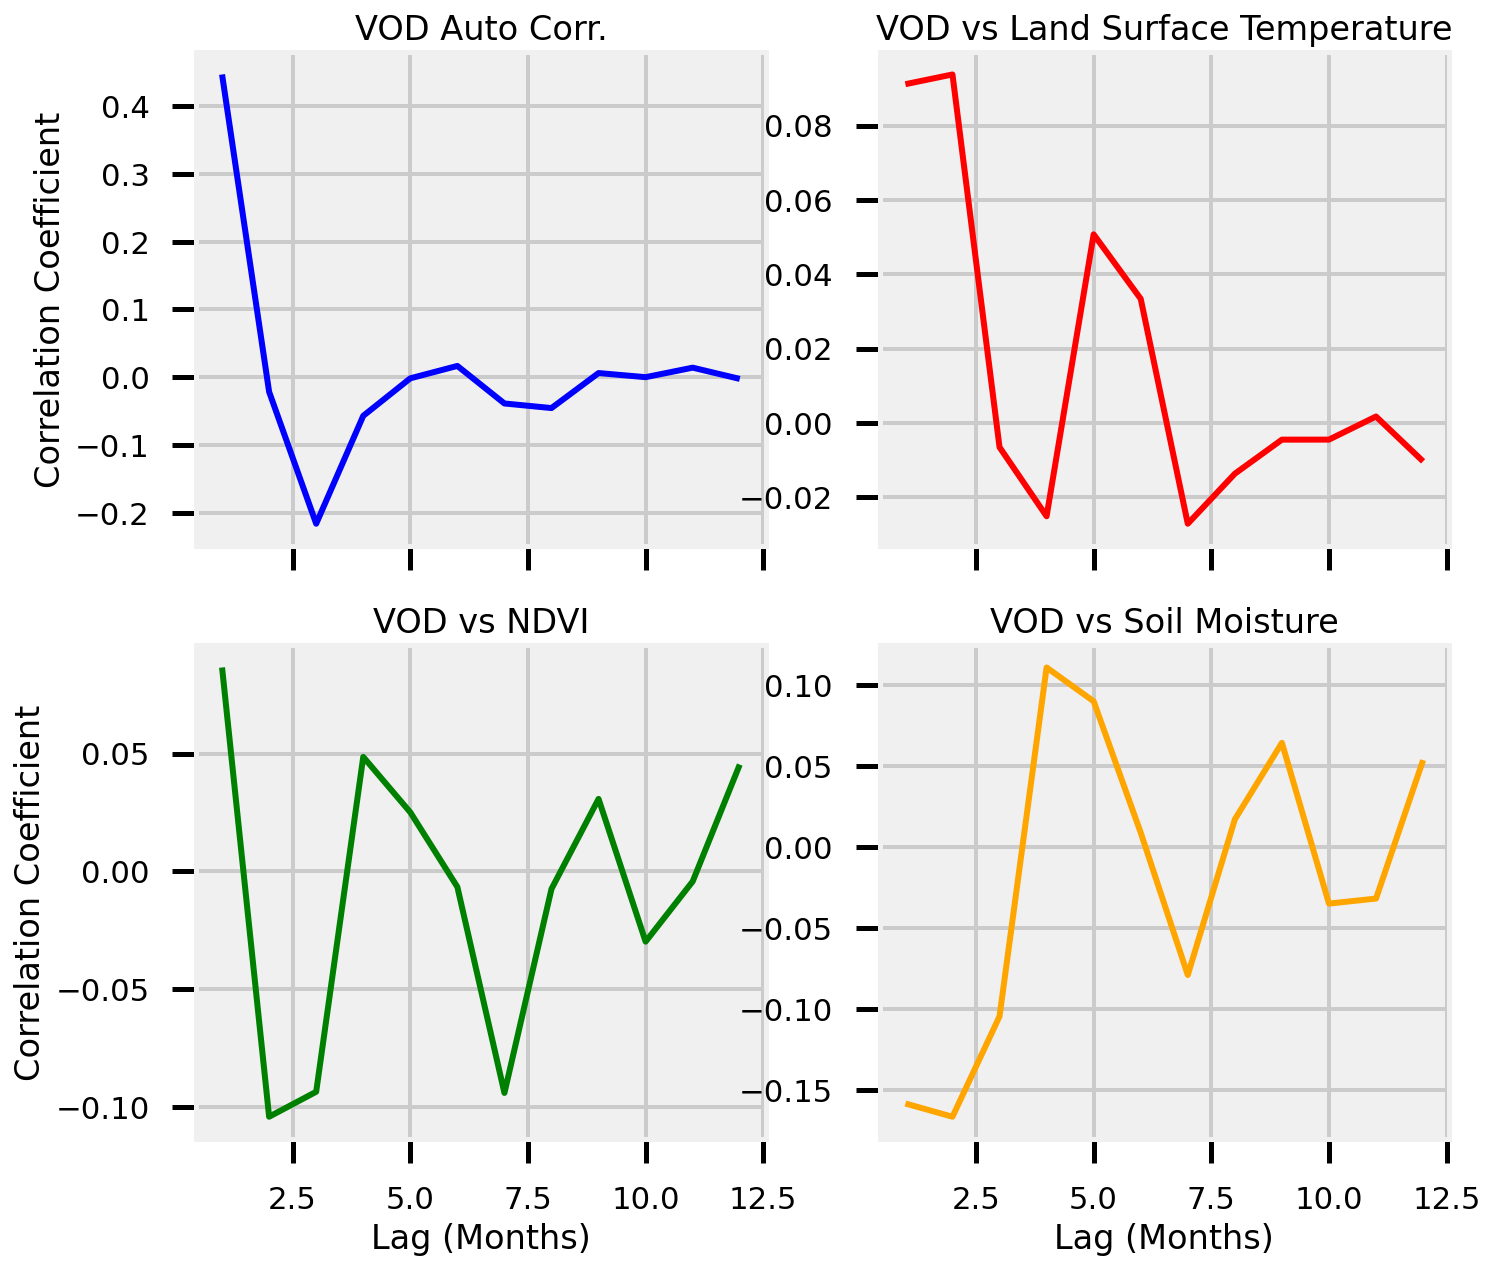

In [19]:
# combine the years
plot_crosscorr(ds.groupby("time.month").mean(), "Lag (Months)")


#### Average Per Year - By Day

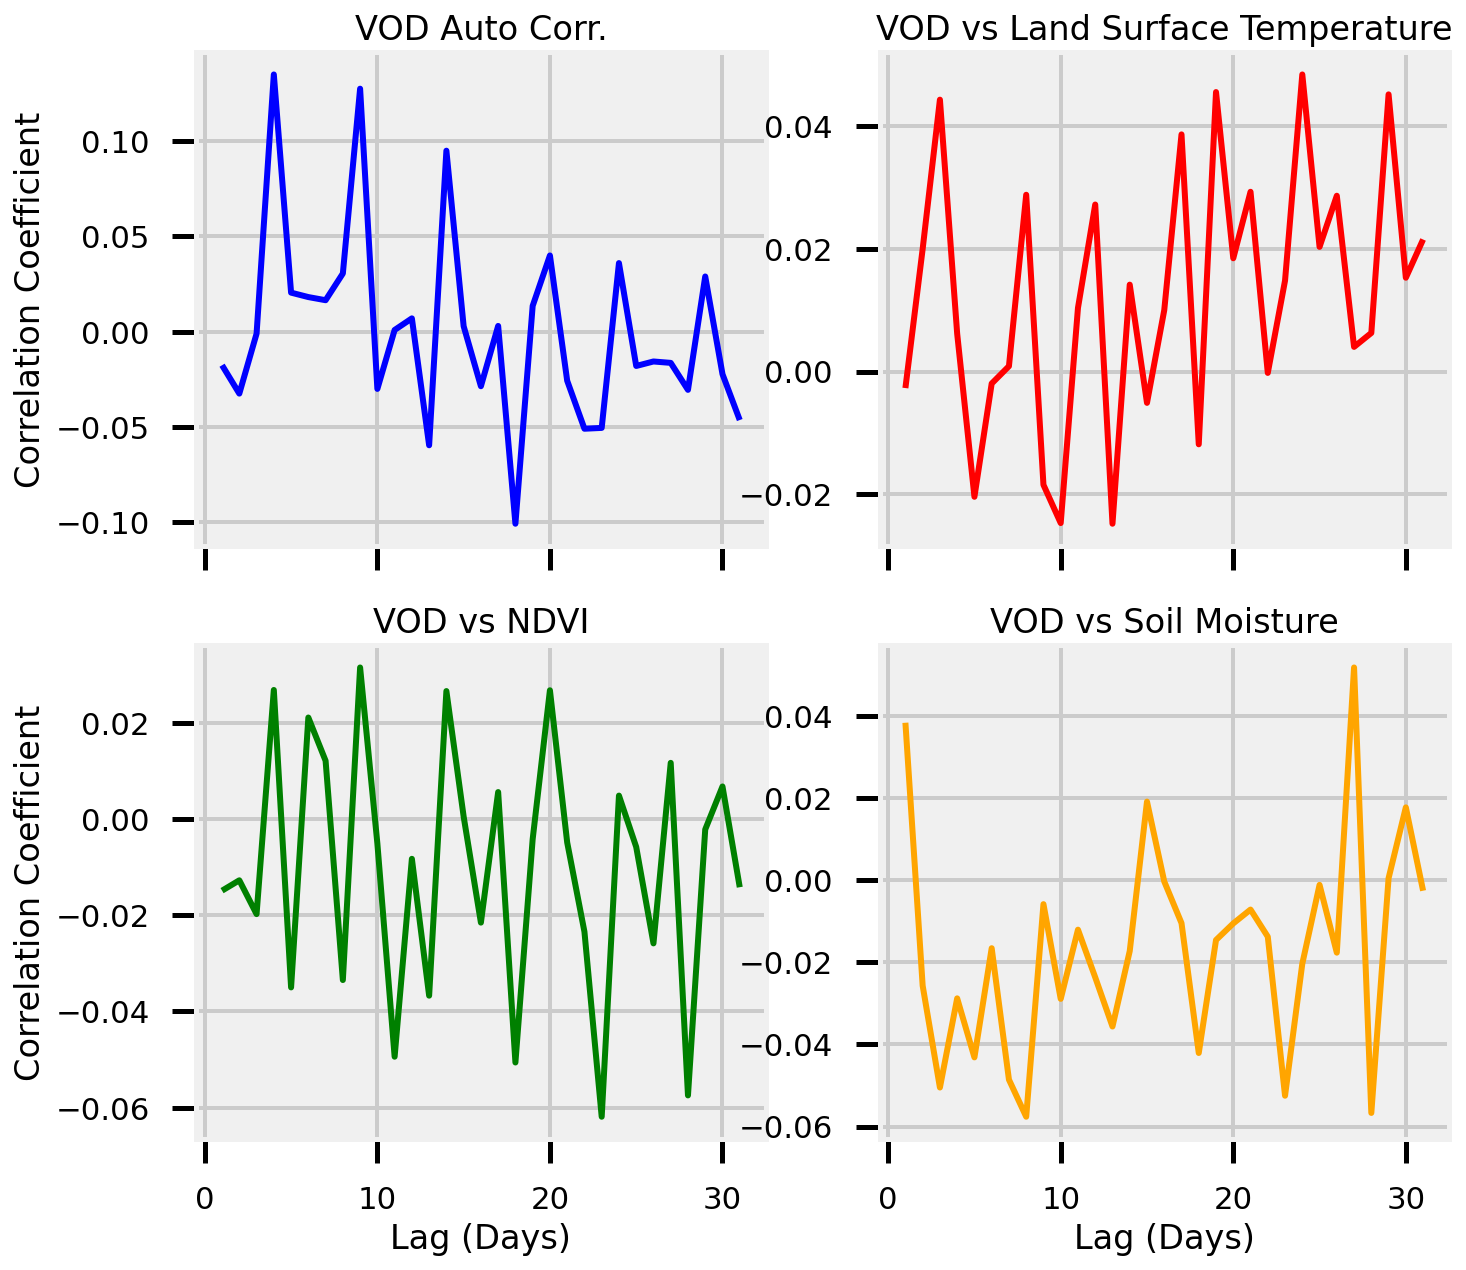

In [20]:
# combine the years
plot_crosscorr(ds.groupby("time.day").mean(), "Lag (Days)")